In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from operator import itemgetter
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from time import time

%matplotlib inline

pfold = os.path.abspath('/Users/agervasi/PycharmProjects/Taarifa') # project folder


# building a dataframe containing features and labels
data_train = pd.read_csv(os.path.join(pfold, 'data/features_train.csv'))
data_test = pd.read_csv(os.path.join(pfold, 'data/features_test.csv'))
data_train['status_group'] = pd.read_csv(os.path.join(pfold, 'data/labels_train.csv')).status_group

# convert dates entered as string into time delta in days
data_train.date_recorded = pd.to_datetime(data_train.date_recorded)
data_test.date_recorded = pd.to_datetime(data_test.date_recorded)
reference_date = datetime.datetime(2000,1,1) # reference date to calculate time deltas
data_train['date_recorded_delta'] = (data_train['date_recorded'] - reference_date)  / np.timedelta64(1,'D')
data_test['date_recorded_delta'] = (data_test['date_recorded'] - reference_date)  / np.timedelta64(1,'D')

## Exploratory Data Analysis

### Dataset structure and Data quality

The test dataset is made of 59400 total entries. Each one consisting of 40 features and one pump status.
Most the features are text entries (like installer name, funder name, etc.) or categorical entries (extraction type group, payment type, etc.). Only a few feature have numerical values (amount_tsh, population) and some are date related (date_recorded, construction_year).

There are sometimes several entries for the same water point. As these entries have different funders and construction years, I guess that they correspond to different pumps. 

Several data quality issues can be spotted:
- the scheme_name feature is showing a high ratio of NaN values, which may be a reason not to use it for the classification algorithm.
- the longitude and latitude features are sometimes entered with values that do not correspond to Tanzanian geographical position
- num_private and recorded_by does not seem to bring any kind of information
- scheme_name is missing a lot of entries
- construction year seems to have some strong outliers (year = 0)

Also, some categorical features include a lot of different category levels (funder, wpt_name, subvillage, installer, ward, scheme_name). In order to use them in my classification algorithm, I will have to reduce this number of category in order to limit the size of my dataset after one-hot-encoding. 

In [2]:
def detail_feature(feature_name, df = data_train):
    '''
    if feature is numerical, plots the data distribution.
    If feature is of object type, plots the object frequency of the 20 most frequent objects. 
    Also plots, for these objects, the split between each status group.
    '''
    print("feature {0} is being detailed:".format(feature_name))
    print(df[feature_name].describe())  # describe the data 
    
    # If feature is number or date
    if df[feature_name].dtype in ["int64", "float64", '<M8[ns]']:       
        fig, (ax1, ax2) = plt.subplots(2,1)

        # Distribution plot
        n, bins, patches = ax1.hist(df[feature_name].values, 50)
        ax1.set_ylabel("Frequency")
        ax1.set_xlabel(feature_name)

        # Box plot
        if df[feature_name].dtype == '<M8[ns]':  # work around for date types, only using year
            data = [df[df["status_group"]=="functional"][feature_name].dt.year.values,
                   df[df["status_group"]=="functional needs repair"][feature_name].dt.year.values, 
                   df[df["status_group"]=="non functional"][feature_name].dt.year.values]
        else:
            data = [df[df["status_group"]=="functional"][feature_name].values,
                   df[df["status_group"]=="functional needs repair"][feature_name].values, 
                   df[df["status_group"]=="non functional"][feature_name].values]

        ax2.boxplot(data, vert=False)
        ax2.set_xlabel(feature_name)
        ax2.set_yticklabels(["functional", 
                             "functional needs repair",
                             "non functional"])

        # Limit the plot window to see the boxplots
        if df[feature_name].dtype == '<M8[ns]':
            data = df[feature_name].dt.year
        else:
            data = df[feature_name]
        x_min = max(np.percentile(data, 25)  - 5*(np.percentile(data, 75) - np.percentile(data, 25)), 
                    min(data))
        x_max = min(np.percentile(data, 75)  + 5*(np.percentile(data, 75) - np.percentile(data, 25)),
                    max(data))
        ax2.set_xlim(x_min,x_max)
        plt.show()
        
    # If feature is of object or categorical type 
    elif df[feature_name].dtype.name in ["object", "category"]:
        
        labels = [c for c in df.groupby(feature_name)[feature_name].groups]  # list of unique objects
                  
        # Frequency for each unique object
        height_tot = [df.groupby(feature_name)[feature_name].get_group(label).count() for label in labels]

        # Frequency for  each unique object, split by pump status
        x_func = []
        x_needrepair = []
        x_nonfunc = []

        groups = df.groupby([feature_name, "status_group"])[feature_name]      
        for x, status in [(x_func, "functional"), (x_needrepair, "functional needs repair"), (x_nonfunc, "non functional")]:
            for label in labels:                
                try:
                    x.append(groups.get_group((label, status)).count())
                except KeyError:
                    x.append(0)
                  
        # Frequency converted into percentage
        for i in range(len(height_tot)):
            x_func[i] = 1.0*x_func[i]/height_tot[i]
            x_nonfunc[i] = 1.0*x_nonfunc[i]/height_tot[i]
            x_needrepair[i] = 1.0*x_needrepair[i]/height_tot[i]        

        main_groups = list(zip(labels, height_tot, x_func, x_needrepair, x_nonfunc))
        main_groups.sort(key=itemgetter(1), reverse=True)  # sort according to the total item frequency

        # Keep only the 20  most frequent objects
        if len(labels) > 20: 
            main_groups = main_groups[:20]                

        # Plots
        width1 = 0.35
        ind = np.arange(len(main_groups))
        fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
        plt.xticks(ind + width1/2., rotation=90)
        
        # Frequency plot
        width1 = 0.35
        ax1.bar(ind, [x[1] for x in main_groups], width1)
        ax1.set_xticklabels([x[0] for x in main_groups])
        ax1.set_title(feature_name)
        ax1.set_ylabel("Frequency")

        # Plot of pump status ratio 
        width2 = 0.35
        ind = np.arange(len(main_groups))        
        bottom2 = [x[2] for x in main_groups]
        bottom3 = [x[2] + x[3] for x in main_groups]
        
        p1 = ax2.bar(ind, [x[2] for x in main_groups], width2, color="g")  # functional
        p2 = ax2.bar(ind, [x[3] for x in main_groups], width2, color="y", bottom=bottom2) # functional needs repair
        p3 = ax2.bar(ind, [x[4] for x in main_groups], width2, color="r", bottom=bottom3) # non functional
        ax2.set_xticklabels([x[0] for x in main_groups])
        ax2.set_ylabel("status_group ratio")

        plt.show()        
    return

## Feature engineering and preselection

In order to reduce the number of categorical features, I only selected the features that seemed relevant to me to predict the pump status. I based my selection on the previous exploratory data analysis. 

I had to deal with missing data and outliers, and I also had to reduce the number of category levels for some categorical features. To do so, I selected the 20 most frequent items and set all the rest to "other".

Before using the dataset with classification algorithms, I implemented one-hot encoding on categorical features. 


### Categorical level reduction

To limit the dataset expansion via one-hot encoding, I decided to reduce the number of categorical level of the following features: "funder", "installer", "ward" and "scheme_name". 

percentage of "other" category in funder: 59.8%


feature funder is being detailed:
count     55765
unique       11
top       other
freq      33346
Name: funder, dtype: object


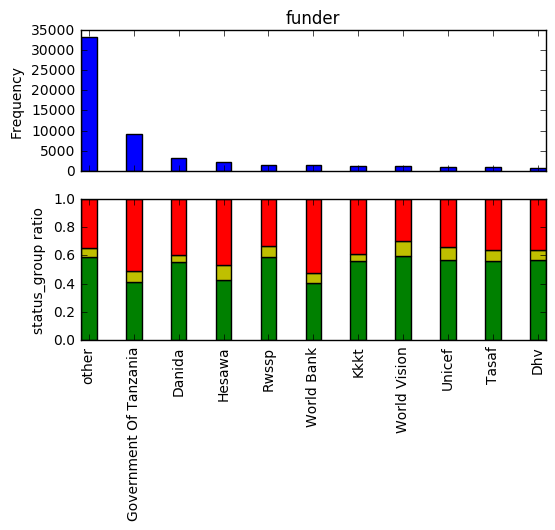

percentage of "other" category in installer: 55.0%


feature installer is being detailed:
count     55745
unique        9
top       other
freq      30687
Name: installer, dtype: object


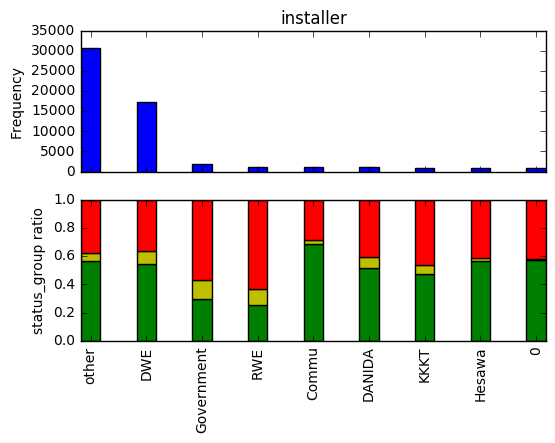

percentage of "other" category in ward: 100.0%


feature ward is being detailed:
count     59400
unique        1
top       other
freq      59400
Name: ward, dtype: object


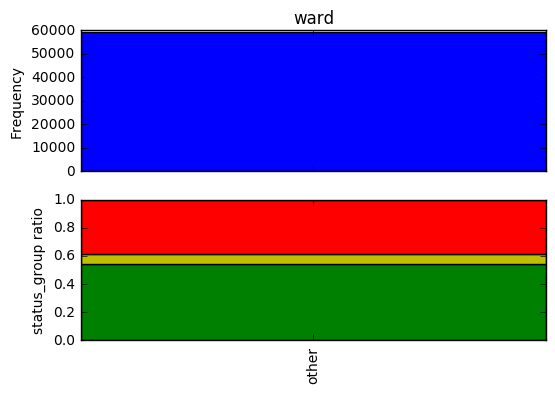

percentage of "other" category in scheme_name: 90.2%


feature scheme_name is being detailed:
count     31234
unique        7
top       other
freq      28178
Name: scheme_name, dtype: object


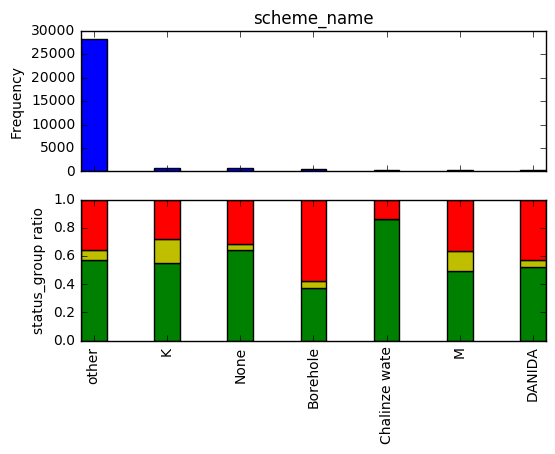

In [4]:
def reduce_cat(feature, max_cat_level=50):
    '''
    For a given feature from the data_train and data_test pandas dataframe: 
    reduce the number of unique values to a specific limit. 
    Set the non-selected values to 'other'
    '''
    groups_train = data_train.groupby(feature)[feature].groups
    groups_test = data_test.groupby(feature)[feature].groups

    # build a sorted list of tuple with the category name and it frequency
    cat_counts = [(key, len(value)) for key,value in groups_train.items()]
    cat_counts += [(key, len(value)) for key, value in groups_test.items()]
    cat_counts = sorted(cat_counts, key=itemgetter(1), reverse=True)

    # keep on the max_cat_level number of category and set "other" value to the rest
    cat_nonselected = cat_counts[max_cat_level:]
    data_train[feature].replace(to_replace=cat_nonselected, value='other', 
                                inplace=True, regex=False)  # Replace in the training set
    other_ratio = len(data_train.groupby(feature)[feature].groups["other"])/1.0/data_train[feature].count()
    print("percentage of \"other\" category in {0}: {1:.1f}%".format(feature, other_ratio*100))
    data_test[feature].replace(to_replace=cat_nonselected, value='other', 
                               inplace=True, regex=False)  # Replace in the test set
    return


for feature in ["funder", "installer", "ward", "scheme_name"]:
    reduce_cat(feature)
    detail_feature(feature)

It appears that using only a limited number of category levels simplifies a lot the feature distribution. But as the previous category were kind of homogeneously distributed, we lose some information and regroup most of the entries into the "other" category.

This is especially true for the "ward" and "scheme_name" feature where more than 90% of the non null entries are set to "other". As a consequence, I decided not to use these two features. 

In [6]:
#  Replacing NaN values by "0"
data_train.funder = data_train.funder.fillna("0")
data_test.funder = data_test.funder.fillna("0")
data_train.installer = data_train.installer.fillna("0")
data_test.installer = data_test.installer.fillna("0")

# Replacing NaN values by average values
longitude_ave = data_train[data_train.longitude != 0].longitude.mean()
latitude_ave = data_train[data_train.latitude != 0].latitude.mean()
permit_ave = data_train.permit.mean()
construction_year_ave = data_train[data_train.construction_year != 0].construction_year.mean()

# if latitude not defined, or unrealistic, replace by the mean
data_train.longitude = data_train.longitude.fillna(longitude_ave)
data_train.loc[:,"longitude"][data_train.longitude < 20] = longitude_ave
data_test.longitude = data_test.longitude.fillna(longitude_ave)
data_test.loc[:,"longitude"][data_test.longitude < 20] = longitude_ave

# if latitude not defined, or unrealistic, replace by the mean
data_train.latitude = data_train.latitude.fillna(latitude_ave)
data_train.loc[:,("latitude")][data_train.latitude > -0.5] = latitude_ave
data_test.latitude = data_test.latitude.fillna(latitude_ave)
data_test.loc[:,("latitude")][data_test.latitude > -0.5] = latitude_ave

# if permit undefined, replace by the mean
data_train.permit = data_train.permit.fillna(permit_ave)
data_test.permit = data_test.permit.fillna(permit_ave)

# if construction_year undefined or unrealistic, replace by the mean
data_train.construction_year = data_train.construction_year.fillna(construction_year_ave)
data_train.loc[:,("construction_year")][data_train.construction_year < 1800] = construction_year_ave
data_test.construction_year = data_test.construction_year.fillna(construction_year_ave)
data_test.loc[:,("construction_year")][data_test.construction_year < 1800] = construction_year_ave

/Users/agervasi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/Users/agervasi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/agervasi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/agervasi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/agervasi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying

/Users/agervasi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### One-hot encoding

In [7]:
df_train = data_train.copy()
df_test = data_test.copy()

# Features selected to be used by the classification algorithm.
selected_features = ["amount_tsh", "date_recorded_delta", "funder", "gps_height", "installer", "longitude", "latitude",
                     "basin", "region", "district_code", "lga", "population", "public_meeting",
                     "scheme_management", "permit", "construction_year", "extraction_type",
                     "management", "payment", "water_quality", "quantity", "source", "waterpoint_type"]

# Drop non pre-selected features
for col in df_train.columns:
    if col not in selected_features:
        df_train = df_train.drop(col, 1)
for col in df_test.columns:
    if col not in selected_features:
        df_test = df_test.drop(col, 1)

            
# Concatenate both dataset to proceed with one-hot encoding, otherwise some objects from the test dataset
# might not appear in the training dataset.
df_test.index = range(len(df_train.index), len(df_train.index) + len(df_test.index))
df = pd.concat([df_train, df_test])           
for col in df.columns:
    if col in selected_features:
        if df[col].dtype.name in ["object",'category']:
            df = pd.get_dummies(df, sparse=True, prefix=col, columns=[col])

df_train = df.loc[df_train.index, :]
df_test = df.loc[df_test.index, :]

df_train.info()

<class 'pandas.sparse.frame.SparseDataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Columns: 268 entries, amount_tsh to waterpoint_type_other
dtypes: float64(268)
memory usage: 121.5 MB


### Machine learning with Random Forest

In [8]:
X = df_train.values
y = data_train.status_group
X_test = df_test.values

param_grid = {
     'n_estimators': [50, 60, 70, 80, 90]
      }
cv = StratifiedShuffleSplit(y, 10, random_state = 42)
clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), 
               param_grid, verbose=0, cv=cv, n_jobs=3)

print("Fitting the classifier to the training set")
t0 = time()
clf = clf.fit(X, y)
print("done in {0:.3f}s".format((time() - t0)))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_score_)

Fitting the classifier to the training set


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


/Users/agervasi/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


done in 317.366s
Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.806464646465


### Machine Learning with XGBoost